In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
np.random.seed(42) # for consistent output in every run

In [2]:
# Getting MNIST data

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [3]:
# shape of mnist data which has 70000 images of numbers from 1 to 9 which has 28*28 = 784 pixel image 
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

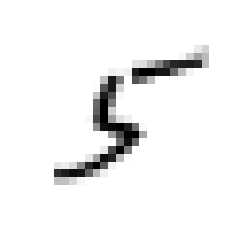

5

In [4]:
# printing a random number

some_digit = X[35000]
some_digit_label = y[35000]

some_digit_fig = some_digit.reshape(28,28)
plt.imshow(some_digit_fig ,cmap = mpl.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show()
some_digit_label

In [5]:
#splitting data - 60000 in test and 10000 in train

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
# shuffling data

shuffle_index = np.random.permutation(60000)
X_train, y_train= X_train[shuffle_index], y_train[shuffle_index]

In [7]:
# producing data for binary classification

y_train_5 = (y_train == 5)
y_test_5 =(y_test == 5)

In [8]:
# SGD CLASSIFIER

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42, max_iter = 5000)

In [9]:
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=5000, random_state=42)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

In [11]:
# SGD CLASSIFIER SCORES BASED ON ACCURACY
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.9613, 0.9635, 0.9661])

In [12]:
# trying to check if I got good accuracy because of biased data
# below is the code to show how accuracy works, which is (total correct predictions/ total dataset length)

In [13]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits = 3)

for train_index, test_index in skfold.split(X_train,y_train_5):
    clone_sgd = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_sgd.fit(X_train_folds,y_train_folds)
    y_pred_clone_sgd = clone_sgd.predict(X_test_folds)
    total_correct = sum(y_pred_clone_sgd == y_test_folds)
    print(total_correct/len(y_test_folds))

0.9613
0.9635
0.9661


In [14]:
#importing baseestimator to make my own classifier which basically always says that it is not 5

from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype = bool)
    

clf = Never5Classifier()
cross_val_score(clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')


array([0.909  , 0.90715, 0.9128 ])

In [15]:
# Still got good score in accuracy because the data is skewed and hence accuracy is not the best parameter to analyse the
# model

In [16]:
# taking all predictions to plot a confusion matrix

from sklearn.model_selection import cross_val_predict
y_pred_5_sgd = cross_val_predict(sgd_clf, X_train, y_train_5,cv =3)

In [17]:
# plotting confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_pred_5_sgd)

array([[54122,   457],
       [ 1725,  3696]], dtype=int64)

In [18]:
# alot of false positive and negatives are there

In [19]:
# getting precision score which equals (true positive/total positve predictions  ^) 

from sklearn.metrics import precision_score
precision_score(y_train_5, y_pred_5_sgd)

0.8899590657356128

In [20]:
3696/(3696+457)

0.8899590657356128

In [21]:
# it is a lot less than the accuracy which shows good room for improvement

In [22]:
#trying another metric, recall = true positive/ total positive values in the dataset <, also called sensitivity

from sklearn.metrics import recall_score
recall_score(y_train_5, y_pred_5_sgd)

0.6817930271167681

In [23]:
3696/(3696+1725)

0.6817930271167681

In [24]:
# from both recall and precision, it can be said that model is biased towards predicting that given instance isn't 5
# i.e okaish specitivity and poor sensitivity 

In [25]:
# harmonic mean of recall and precision, to get a single number from two

from sklearn.metrics import f1_score
f1_score(y_train_5, y_pred_5_sgd)

0.7720910800083559

In [26]:
2*0.68*0.88/(0.68+0.88)

0.7671794871794873

In [27]:
# getting probabilities for plotting precision vs recall

from sklearn.model_selection import cross_val_predict
y_pred_5_prob_sgd = cross_val_predict(sgd_clf, X_train,y_train_5, cv=3, method = 'decision_function')

In [28]:
# precision recall curve gives precision and recall values for each threshold value

from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(y_train_5 , y_pred_5_prob_sgd)

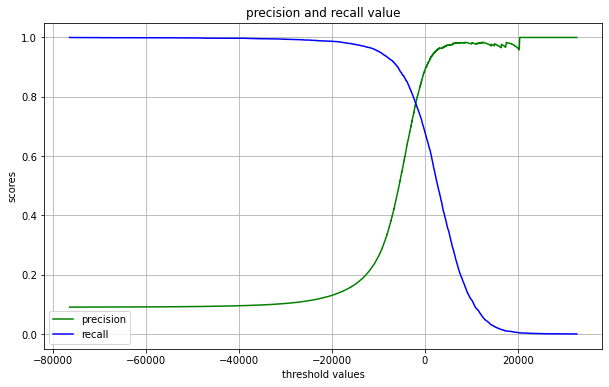

In [29]:
# function to plot precision vs recall curve

def plot_precision_recall_curve(precision, recall, threshold):
    plt.figure(figsize = (10,6))
    plt.plot(threshold,precision[:-1],'g-',label = 'precision')
    plt.plot(threshold,recall[:-1],'b-',label = 'recall')
    plt.xlabel('threshold values')
    plt.ylabel('scores')
    plt.legend()
    plt.grid()
    plt.title('precision and recall value')

plot_precision_recall_curve(precision, recall, threshold)
plt.show()

In [30]:
# Curve one shows that there is a clear tradeoff between precision and recall
# as threshold is increased, precision increases because criteria to recognise as 5 is increased, 
### pro - high probability that predicted 5 is 5, or spam marked email is spam,
### con - too many 5's are left out because the model isn't good enough

# as threshold is decreased, recall increases because any number will now look more like 5 to the model
### pro - alot of 5's can easily be detected, cancer patients detected
### con - alot of bad prediction make the model biased and useless if data is skewed

In [31]:
precision.shape#WHY????????????????????????????????

# because different instances can have same threshold value and precision and recall are a function of threshold

(59719,)

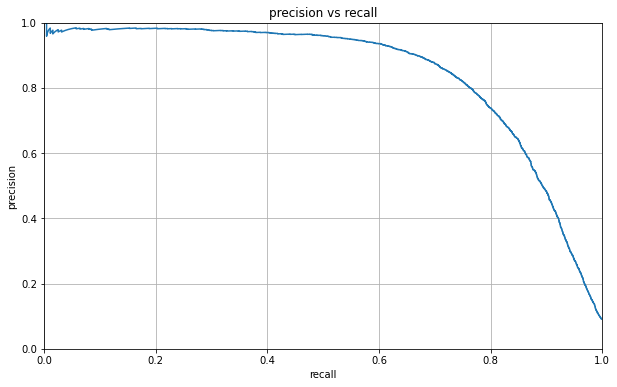

In [32]:
# plotting precision vs recall
def plot_precision_vs_recall(precision, recall):
    plt.figure(figsize=(10,6))
    plt.plot(recall,precision)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('precision vs recall')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.grid()
    

plot_precision_vs_recall(precision, recall)
plt.show()

In [33]:
# more clear understanding of how precision recall tradeoff works

In [34]:
# if 0.8 is chosen as precision then as recall is also about 7 and threshold at this value of precision is approximately -1500

In [35]:
# function for getting errors metrics
def error(y_train,y_pred):
    print('Precision\t',precision_score(y_train,y_pred))
    print('recall\t\t',recall_score(y_train,y_pred))
    print('f1 score\t',f1_score(y_train,y_pred))

In [36]:
y_precision_80 = (y_pred_5_prob_sgd>-1500)
error(y_train_5,y_precision_80)

Precision	 0.8072241853160581
recall		 0.758531636229478
f1 score	 0.7821207798383262


In [37]:
precision[:-1].shape

(59718,)

In [38]:
threshold.shape

(59718,)

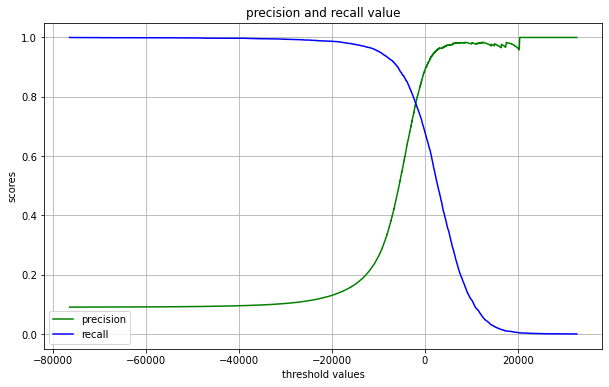

In [39]:
plot_precision_recall_curve(precision,recall,threshold)

In [40]:
# pretty good precision and recall & F1 SCORE but there still is a lot of room for improvement

when you care more about TP prefer the above(pretty vague statement written in book which I don't understand yet)

In [41]:
# roc - receiver operating characteristics

from sklearn.metrics import roc_curve
fpr_sgd,tpr_sgd,threshold = roc_curve(y_train_5,y_pred_5_prob_sgd)

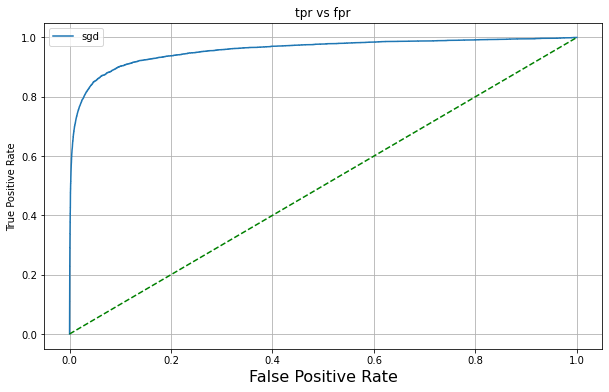

In [42]:
# PLOTTING roc curve = TPR(sensitivity or recall) vs FPR(inspecificity or 1-(specificity))

def plot_roc(fpr,tpr, clf):
    x = np.linspace(0,1,20)
    plt.figure(figsize = (10,6))
    plt.plot(fpr,tpr,label = clf)
    plt.legend()
    plt.plot(x,x,'g--')
    plt.title('tpr vs fpr')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate')
    plt.grid()

plot_roc(fpr_sgd,tpr_sgd,'sgd')
plt.show()

In [43]:
# Line in the mid represents the dumbest model, aim should be to stay away from that line to the uper side of plane

In [44]:
# roc_auc score gives the area under the graph, more it is, better the model is

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_precision_80)

0.8702696840705096

In [45]:
# f1 score says 0.8, this roc auc score says 0.9,
# I still have to understand the basic difference between the two and which one to choose and I hope to learn when I start 
# developing my own projects

In [46]:
# RANDOM FOREST CLASSIFIER, once I am done with sgd, i am changing the model to see the performance of different models on my
# data

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
y_pred_5_rfc = cross_val_predict(rfc, X_train , y_train_5, cv=3, method = 'predict_proba')

In [47]:
fpr_rfc,tpr_rfc,threshold_rfc = roc_curve(y_train_5,y_pred_5_rfc[:,1])

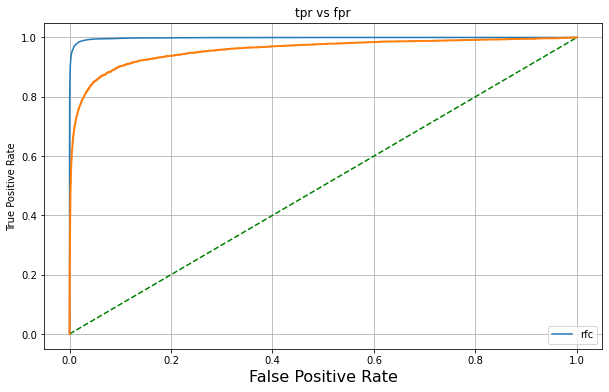

In [48]:
plot_roc(fpr_rfc, tpr_rfc , 'rfc')
plt.plot(fpr_sgd,tpr_sgd,label = 'sgd', linewidth = 2)
plt.show()

In [49]:
# just tried something and found that random forest is a lot better than sgd

In [50]:
roc_auc_score(y_train_5,y_pred_5_rfc[:,1])

0.9983799471718179

In [51]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# pipe = Pipeline([('scalar',StandardScaler()), ('sgd', SGDClassifier())])
# pipe.fit(X_train,y_train_5)
# pipe.precision(X_train,y_train_5)

In [52]:
# pipe.precision(X_train,y_train_5)

## MULTICLASS CLASSIFICATION

In [53]:
# Random Forest and naive bayes directly handle multiclass classification
# binary classifiers convert the task into binary classification problem via OvO or OvA

In [54]:
# SGD is a binary classifier and hence uses OvA strategy to tackle multiclass problems by default

sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [55]:
some_digit_scores = sgd_clf.decision_function([some_digit])

In [56]:
#above is the score/ probability of being a digit 5 or 6 and so on...
# the above score shows that sgd uses OvA i.e one vs all type of classification and predicts the probability of instance 
# being a number in a predefined set of numbers

In [57]:
some_digit_scores.argmax()

5

In [58]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

## OvO and OvA

In [59]:
# In OvA, 10 different times the classification is done on the whole dataset
# In OvO, 10*(10-1)/2 times, i.e all pair combinations are evaluated on partial datasets

In [60]:
# to interchange between OvO and OvA strategy
#SGD

from sklearn.multiclass import OneVsOneClassifier
ovo_sgd_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_sgd_clf.fit(X_train,y_train)

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [61]:
ovo_sgd_clf.predict([some_digit])
len(ovo_sgd_clf.estimators_)

45

In [62]:
10*9/2

45.0

In [63]:
#RFC can handle multiclass problems directly

rfc.fit(X_train,y_train)

RandomForestClassifier()

In [64]:
rfc.predict([some_digit])

array([5], dtype=int8)

In [65]:
rfc.predict_proba([some_digit])

array([[0.  , 0.02, 0.  , 0.  , 0.  , 0.96, 0.  , 0.01, 0.01, 0.  ]])

In [66]:
#SGD
#here accuracy can be used unlike binary class classification for 5 as it is not a sparse data
cross_val_score(sgd_clf,X_train,y_train,cv =3 , scoring = 'accuracy')

array([0.88875, 0.8722 , 0.87905])

In [67]:
#OPTIMISING SGD

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled,y_train, cv = 3, scoring = 'accuracy')

array([0.90355, 0.9005 , 0.9003 ])

In [68]:
#RFC
cross_val_score(rfc, X_train,y_train,cv = 3, scoring = 'accuracy')

array([0.96595, 0.9656 , 0.96645])

In [69]:
#OPTIMISING RFC

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train.astype(np.float64))
cross_val_score(rfc, X_train_scaled,y_train, cv = 3, scoring = 'accuracy')

array([0.9659, 0.9646, 0.9654])

## Error Analysis

In [70]:
#Plotting confusion matric for rfc

y_pred_rfc = cross_val_predict(rfc, X_train_scaled, y_train, cv = 3)
conf_mat = confusion_matrix(y_train,y_pred_rfc)
conf_mat

array([[5843,    1,   12,    2,    5,    8,   18,    1,   29,    4],
       [   0, 6642,   39,   13,   10,    2,    7,   13,   10,    6],
       [  22,   10, 5765,   28,   27,    3,   18,   40,   38,    7],
       [   5,    9,   87, 5805,    2,   70,    7,   50,   64,   32],
       [   9,   10,    9,    0, 5655,    1,   26,    8,   20,  104],
       [  23,    8,   10,   84,   12, 5170,   42,    7,   38,   27],
       [  26,   10,    4,    1,    8,   35, 5817,    0,   17,    0],
       [   5,   21,   61,    6,   43,    1,    0, 6044,    9,   75],
       [  12,   29,   31,   41,   36,   45,   29,    5, 5563,   60],
       [  22,   10,   15,   75,   68,   19,    3,   53,   44, 5640]],
      dtype=int64)

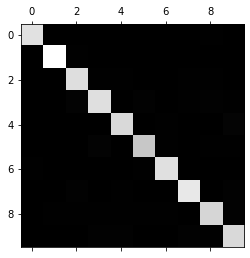

In [71]:
#Graphical representation of confusion matrix

plt.matshow(conf_mat, cmap = plt.cm.gray)
plt.show()

In [72]:
#normalizing confusion matrix

row_sum = conf_mat.sum(axis =1,keepdims = True) # keepdims is for changing shape of row sum
normal_conf_mat = conf_mat/row_sum
np.fill_diagonal(normal_conf_mat,0)

In [73]:
a = np.array([[0,1,2,3],
     [1,0,2,3],
     [3,4,6,7]])

print(a.sum() ,'\n\n',
      a.sum(axis = 1), a.sum(axis = 1).shape ,'\n\n',
      a.sum(axis = 1, keepdims = True),a.sum(axis = 1, keepdims = True).shape)

32 

 [ 6  6 20] (3,) 

 [[ 6]
 [ 6]
 [20]] (3, 1)


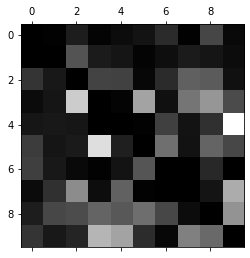

In [74]:
plt.matshow(normal_conf_mat,cmap = plt.cm.gray)
plt.show()

In [75]:
# lot of 9's are classified as 4 and vice versa

In [76]:
a = 4
b = 9
aa = X_train[(y_train == a) & (y_pred_rfc == a)]
ab = X_train[(y_train == a) & (y_pred_rfc == b)]
ba = X_train[(y_train == b) & (y_pred_rfc == a)]
bb = X_train[(y_train == b) & (y_pred_rfc == b)]

In [77]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

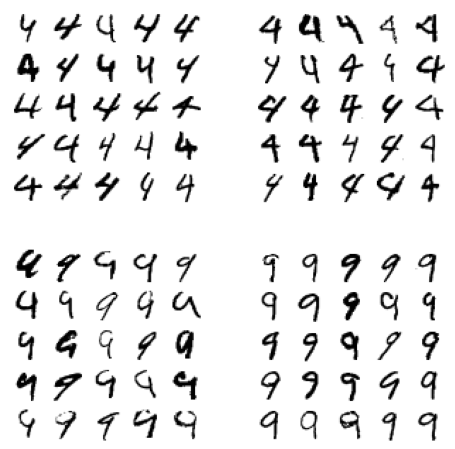

In [78]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(bb[:25], images_per_row=5)

In [79]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3, n_jobs = -1)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=3)

In [80]:
from sklearn.metrics import accuracy_score
y_test_pred = knn.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.9705

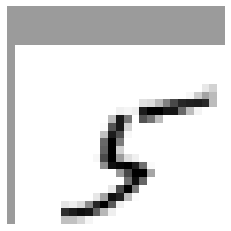

In [81]:
from scipy.ndimage.interpolation import shift

def shift_digit(intance, dx, dy, new):
    return shift(intance.reshape(28,28), [dx,dy], cval = new).reshape(784)

some_digit_fig = shift_digit(some_digit, 5, 1, 100).reshape(28,28)
plt.imshow(some_digit_fig ,cmap = mpl.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show()

In [82]:
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

TypeError: shift_digit() missing 1 required positional argument: 'new'